https://github.com/Amandawei067/HW3-441B

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# 0.) Clean the Apple Data to get a quarterly series of EPS.

In [20]:
y=pd.read_csv("AAPL_quarterly_financials.csv")

In [21]:
# 将y的索引设置为name这一列，这通常用于当我们想要基于某个属性重置索引时
y.index = y.name

# 从y中选择名为"BasicEPS"的行，然后选择从第三行开始到最后的所有行
# 这里使用.loc[]是基于标签的选择，而.iloc[2:,:]是基于整数位置的选择，从第三行开始到末尾
y = pd.DataFrame(y.loc["BasicEPS", :]).iloc[2:, :]

# 将y的索引转换为日期时间格式，这对于时间序列分析特别有用
y.index = pd.to_datetime(y.index)

# 对y按照索引进行排序，并填充缺失值为0.0
# sort_index()确保数据根据时间顺序排列，fillna(0.)则是将所有缺失值替换为0.0
y = y.sort_index().fillna(0.)


In [27]:
y.head()

,BasicEPS
2004-03-31,0.002
2004-06-30,0.003
2004-09-30,0.0
2004-12-31,0.013
2005-03-31,0.013


# 1.) Come up with 6 search terms you think could nowcast earnings. (Different than the ones I used) Add in 3 terms that that you think will not Nowcast earnings. Pull in the gtrends data. Clean it to have a quarterly average.

In [22]:
from pytrends.request import TrendReq

In [25]:
# Create pytrends object
pytrends = TrendReq(hl='en-US', tz=360)

# Set up the keywords and the timeframe
keywords = ["Recession","Samsung","Interest Rate", "New Phone","Buy iPhone","Sell iPhone" ,"Taylor Swift Tickets","Hospital","UCLA"]  # Add your keywords here
start_date = '2004-01-01'
end_date = '2024-01-01'

# Create an empty DataFrame to store the results
df = pd.DataFrame()

# 遍历关键词列表，获取每个关键词的趋势数据
for keyword in keywords:
    # 构建查询载荷，设置关键词、类别、时间范围、地区和Google属性（如YouTube）
    pytrends.build_payload([keyword], cat=0, timeframe=f'{start_date} {end_date}', geo='', gprop='')
    # 获取关键词随时间变化的兴趣度数据
    interest_over_time_df = pytrends.interest_over_time()
    # 将获取到的数据中对应关键词的列添加到之前创建的空DataFrame中
    df[keyword] = interest_over_time_df[keyword]

In [26]:
# 使用“Q”参数对df进行重采样，计算每个季度的平均值，Q表示季度
X = df.resample("Q").mean()

# 使用pd.concat沿着列（axis=1）方向合并y和X数据框，然后使用.dropna()去除含有NaN值的行
# 这样做的目的是保证y和X在时间序列上对齐，同时剔除因缺失数据导致的不完整行
temp = pd.concat([y, X], axis=1).dropna()

# 从合并后的数据框temp中提取"BasicEPS"列作为目标变量y
y = temp[["BasicEPS"]].copy()

# 从合并后的数据框temp中提取除了"BasicEPS"之外的其他列作为特征变量X
# 使用.iloc[:,1:]是因为假定"BasicEPS"是第一列，这样操作提取从第二列到最后一列的所有数据
X = temp.iloc[:, 1:].copy()


# 2.) Normalize all the X data

In [ ]:
# lasso一定要先标准化x

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4.) Run a Lasso with lambda of 0.01. Plot a bar chart.

In [30]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 0.01)
lasso.fit(X_scaled,y)
#获取lasso的系数
coefficients = lasso.coef_

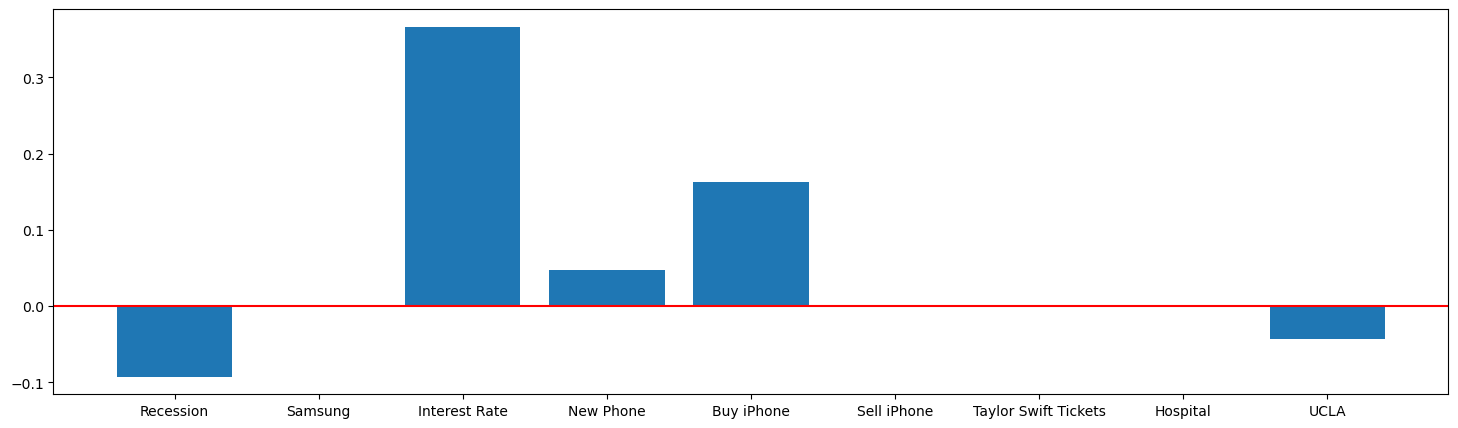

In [31]:
plt.figure(figsize = (18,5))
plt.bar(range(len(coefficients)),coefficients,tick_label=X.columns)
plt.axhline(0.,color = "red")
plt.show()

# 5.) Do these coefficient magnitudes make sense?

I think these coeffecients make sense. The relevent metrics we chose mostly have non-zero coeffecients, while the unrelevent metrics' coeffecients shrink to zero. To be more specific, interest rate, buy iPhone and iPhone have the highest contribution to the prediction of the earnings, which also make sense.

# 6.) Run a for loop looking at 10 different Lambdas and plot the coefficient magnitude for each.

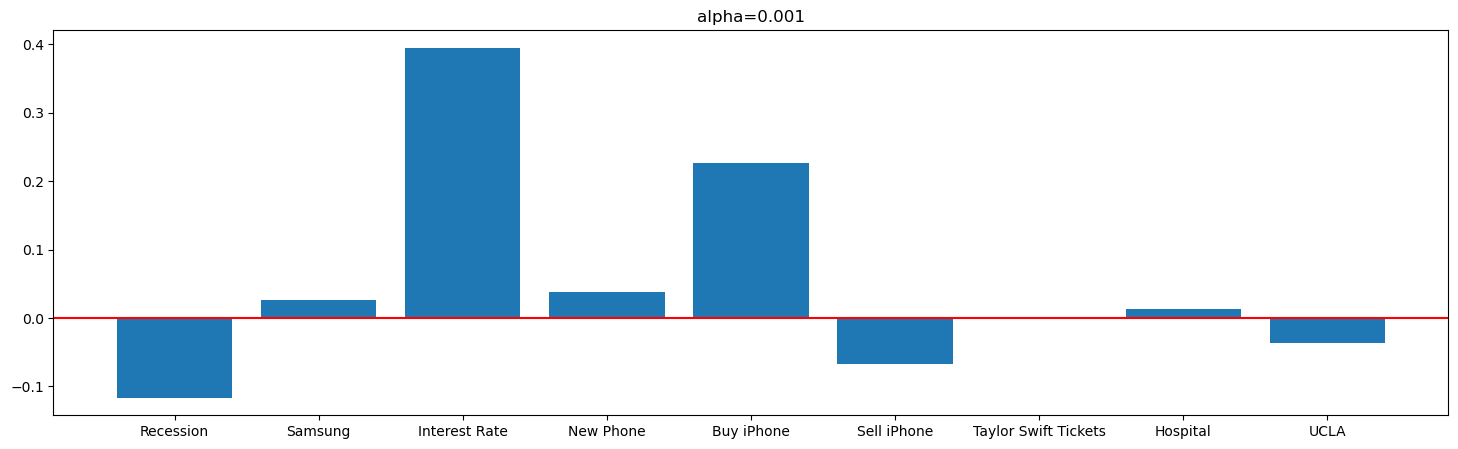

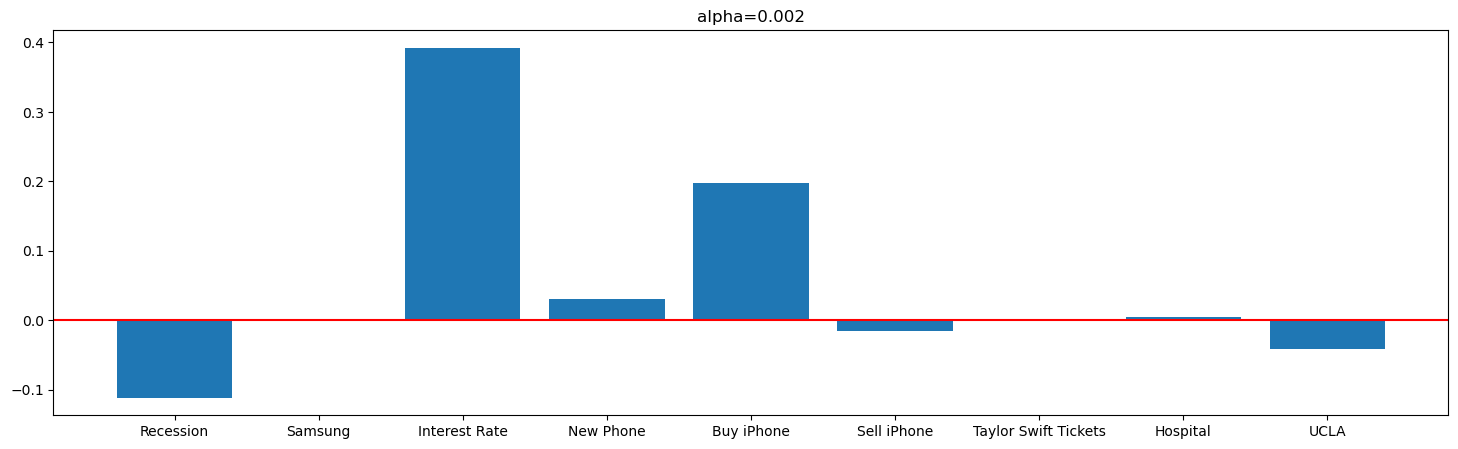

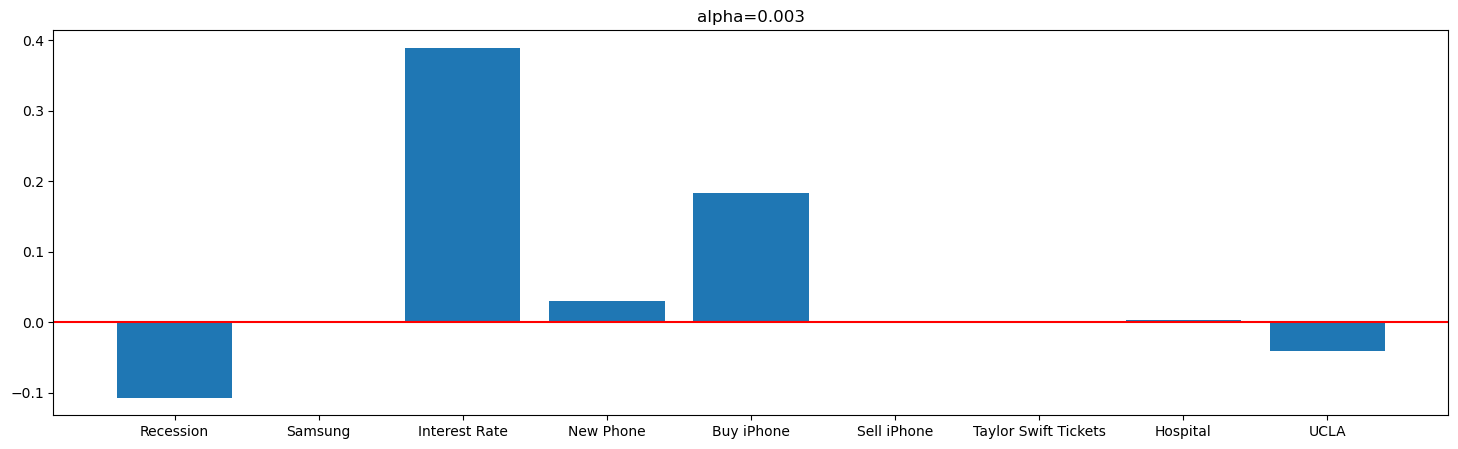

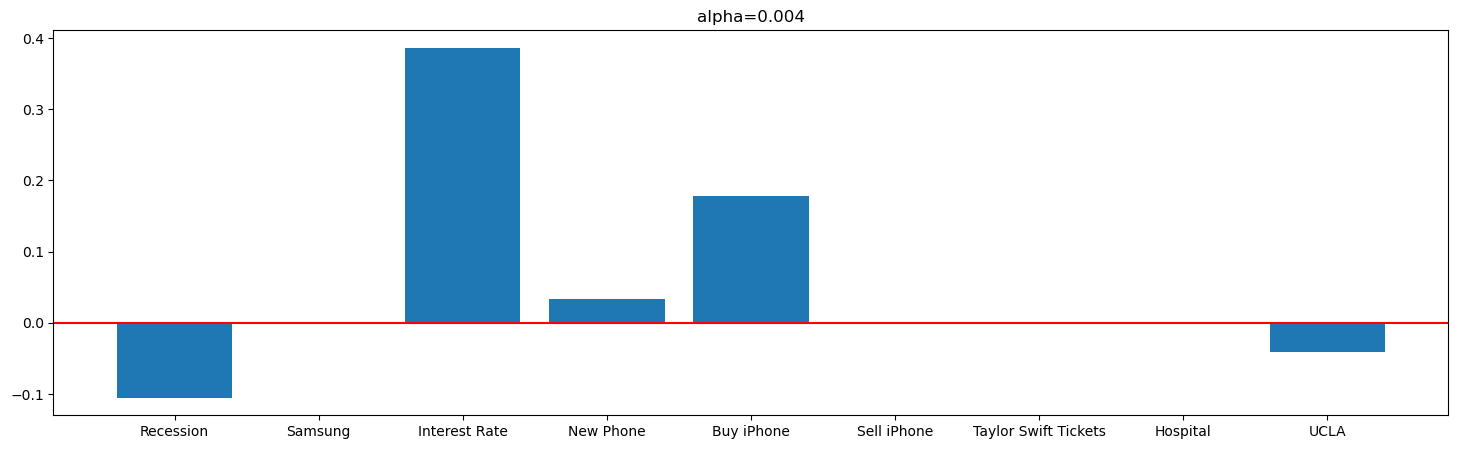

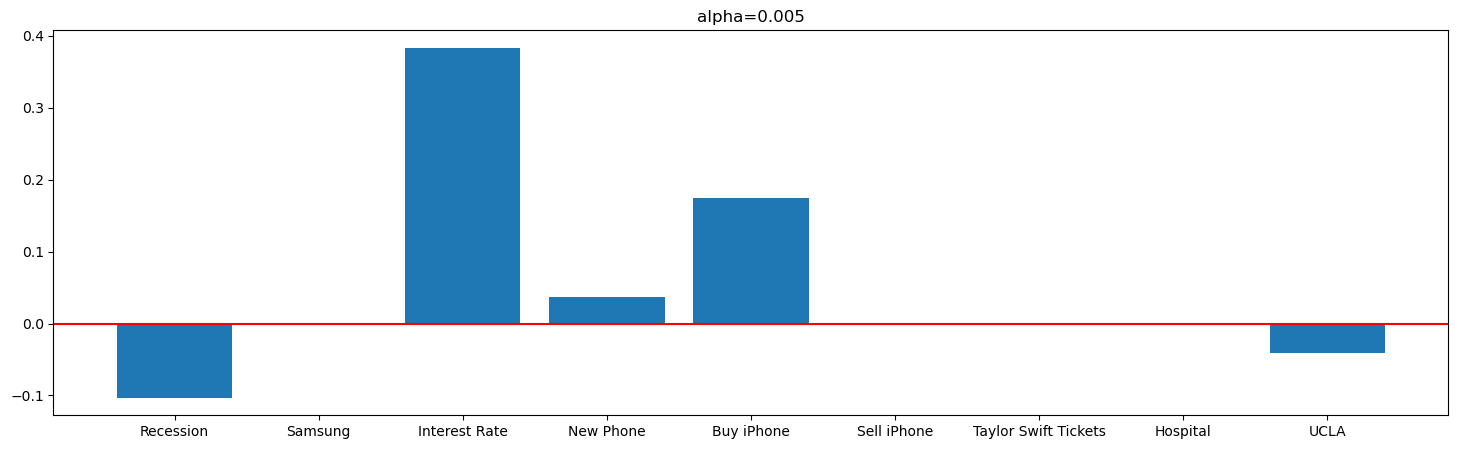

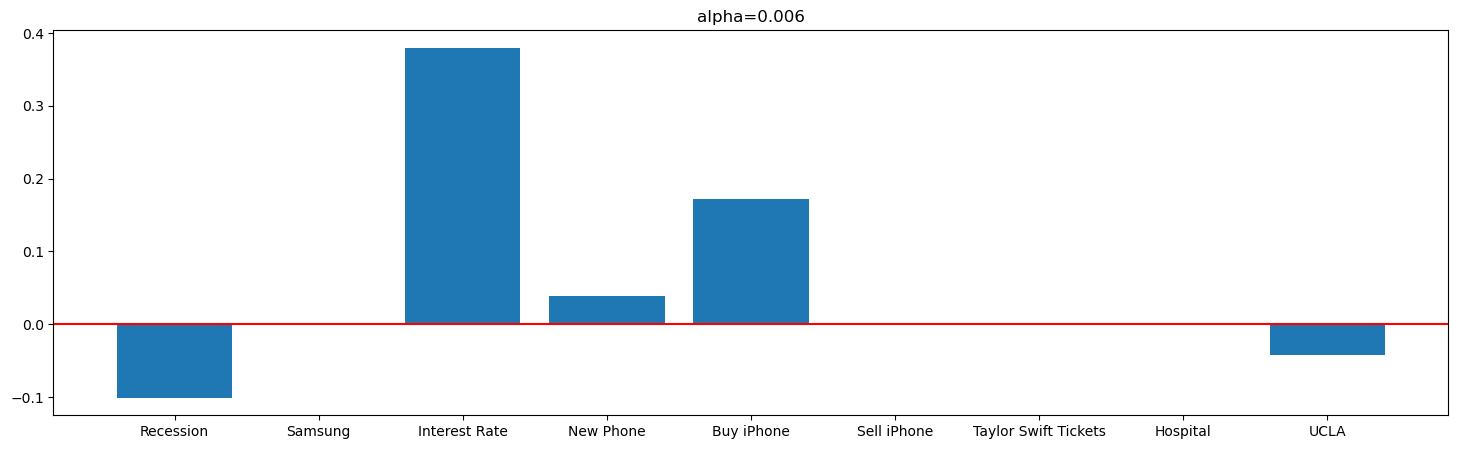

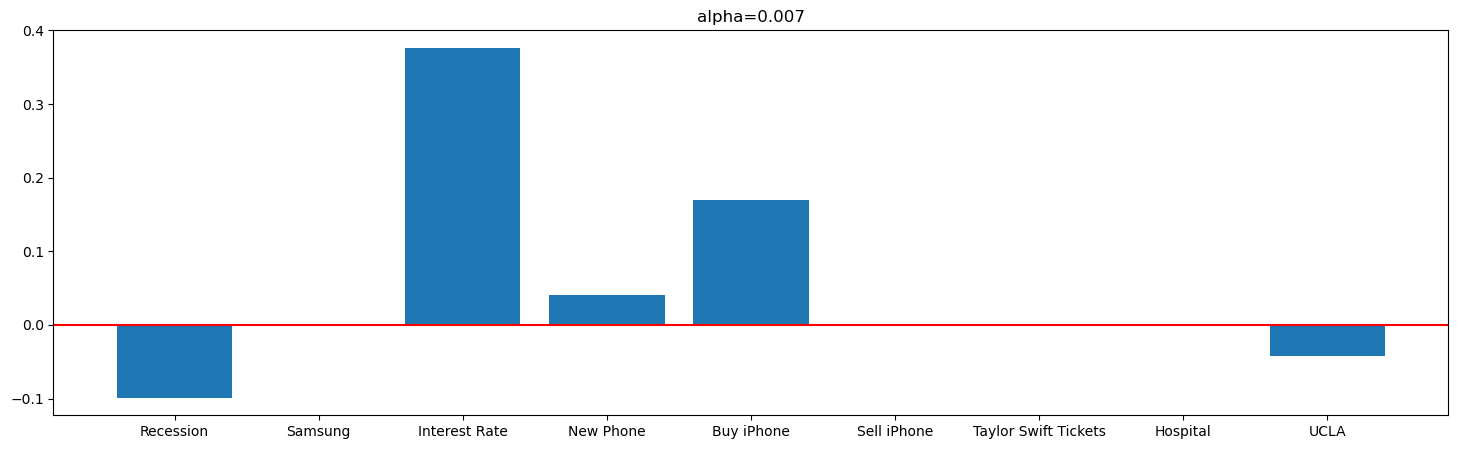

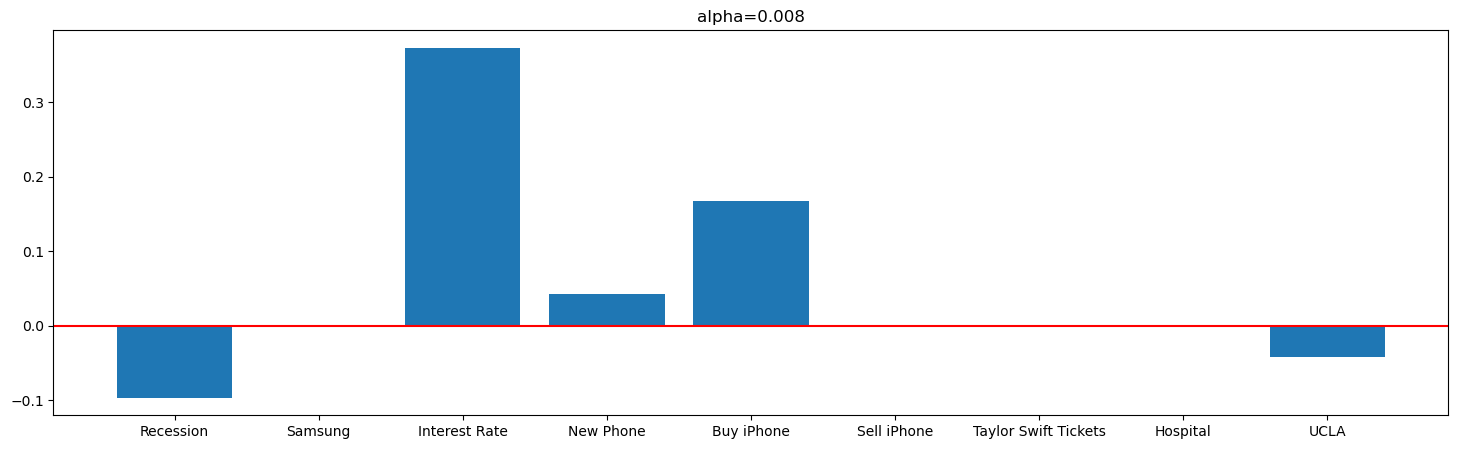

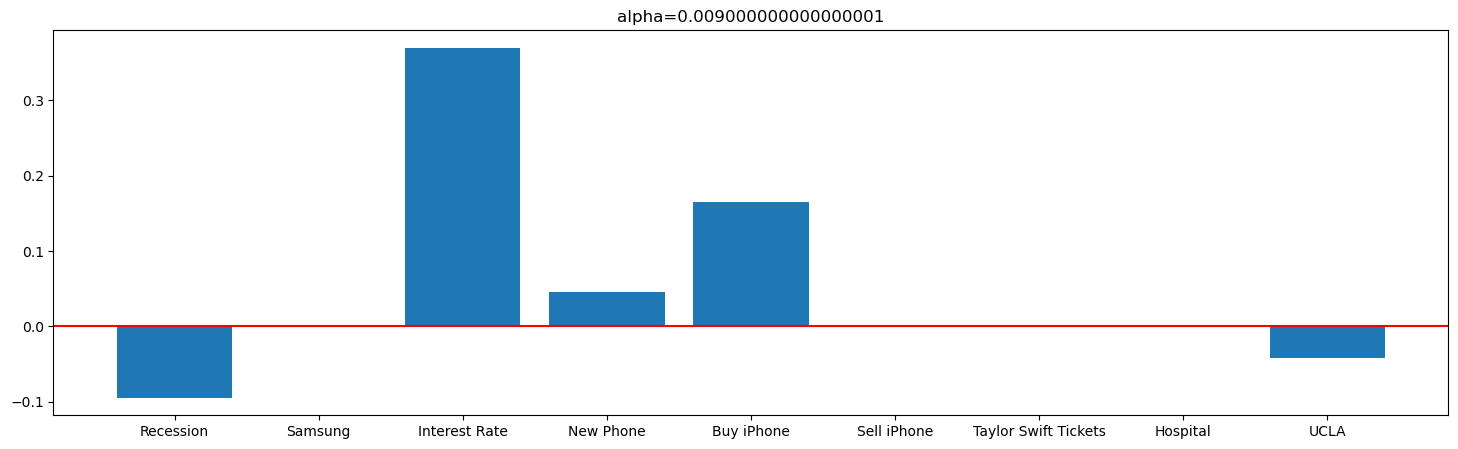

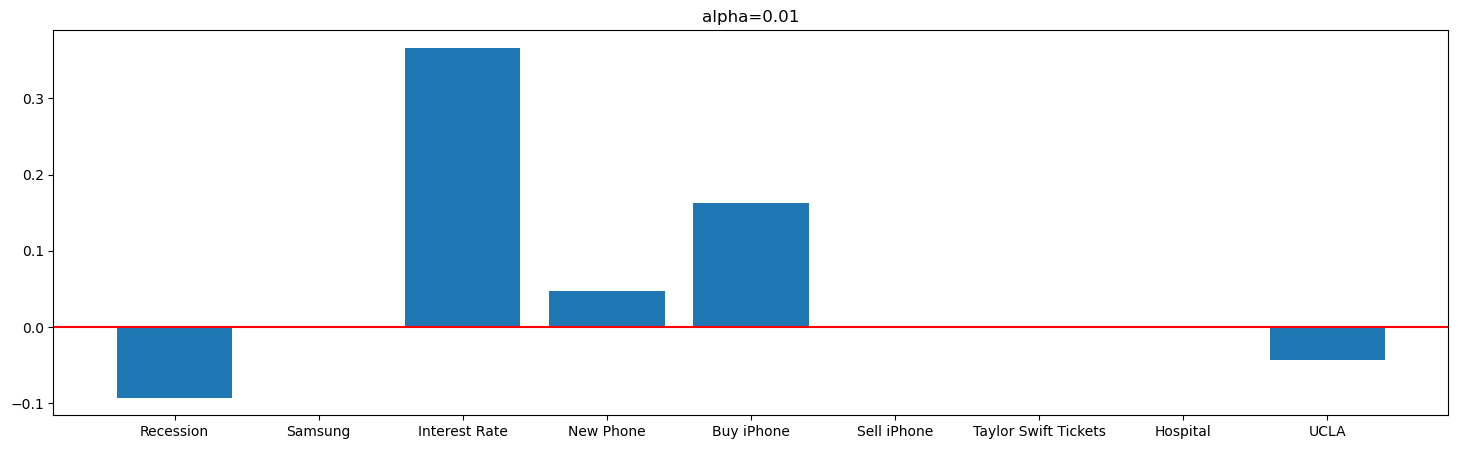

In [47]:
r=np.linspace(0.001, 0.01, 10)
for alpha in r:
    lasso = Lasso(alpha = alpha)
    lasso.fit(X_scaled,y)
    coefficients = lasso.coef_
    
    plt.figure(figsize = (18,5))
    plt.bar(range(len(coefficients)),coefficients,tick_label=X.columns)
    plt.title('alpha={}'.format(alpha))
    plt.axhline(0.,color = "red")
    plt.show()

# 7.) Run a cross validation. What is your ideal lambda?

In [34]:
from sklearn.linear_model import LassoCV
import numpy as np

In [39]:
lasso_model = LassoCV(alphas=np.linspace(0.0001, 0.01, 1000), cv=5)
lasso_model.fit(X_scaled,y)

coefficients = lasso_model.coef_
print(lasso_model.alpha_)

0.0025576576576576576


/Users/weijiayu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


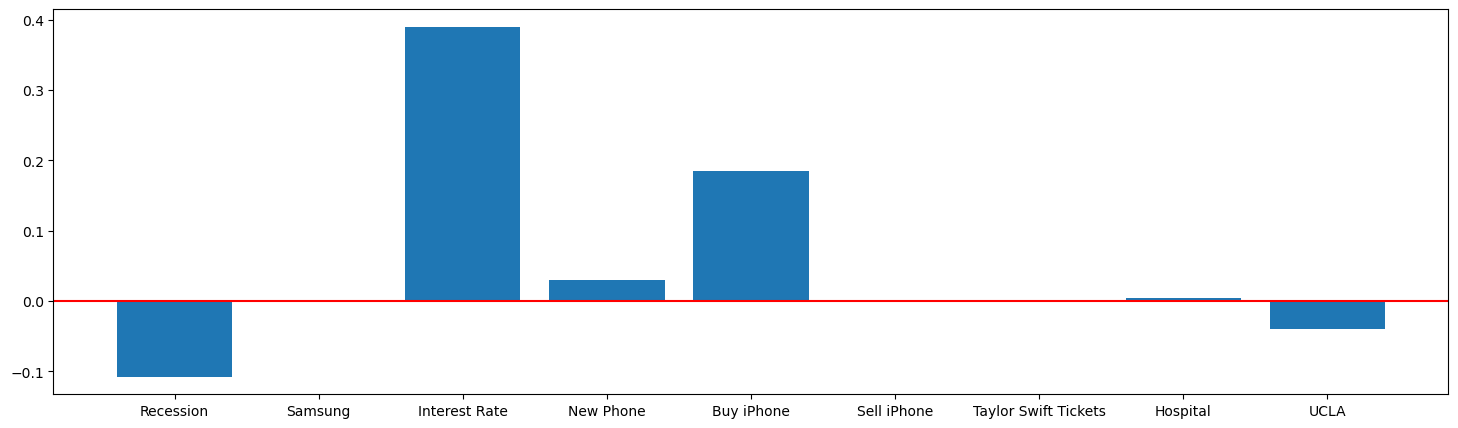

In [40]:
plt.figure(figsize = (18,5))
plt.bar(range(len(coefficients)),coefficients,tick_label=X.columns)
plt.axhline(0.,color = "red")
plt.show()